# 3. Mood Detection of Tweets - Word Embeddings and LSTM

Now that we have our cleaned dataset, we will now continue to train a neural network to classify a tweet's mood.

## Testing for CUDA-enabled TF with GPU Support

**What this means:**
Deep Learning requires a lot of matrix calculations and your CPU is not really meant for that sort of task. However, graphics cards (the hardware that your computer uses to make games run well) are able to perform these sort of tasks very well, so we need to check if the Jupyter Notebook has access to your (Nvidia) GPU, in order to train the model much more efficiently.

In [1]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [2]:
print(tf.test.is_built_with_cuda())
print(tf.keras.__version__)
print(tf.__version__)

True
2.2.4-tf
1.13.1


## Processing our mood tweets dataset

Dataset can also be accessed at: [future Kaggle link for my dataset] 


### Reading the CSV dataset with pandas

In [3]:
import pandas as pd

df = pd.read_csv("datasets/mood_tweets.csv")
df.drop(df.columns[0], inplace=True, axis=1)
df["tweet"] = df["tweet"].astype(str)
df.head()

,class,tweet
0,suicidal,"""He was lost & scared"" says a Newport woman ab..."
1,suicidal,@TheDumbMedico Ameen. Or ye suicide wali bat a...
2,suicidal,You showed the leak in @HouseofCommons today @...
3,suicidal,The number in my bio is for a Suicide hotline ...
4,suicidal,cw: suicidal ideation it's unsurprisingly hard...


In [4]:
df.describe()

,class,tweet
count,25758,25758
unique,6,25758
top,cheerful,@JackieDP @LandSheriffs Have you done your acc...
freq,5885,1


Now let's analyse how the dataset is lain out and roughly how the data looks like

In [5]:
pd.set_option('display.max_colwidth', -1) # option to be set so that the tweet's texts won't be truncated
df.sort_values("class", inplace=True)
display(df.head())
display(df.tail())
df["class"].unique()

,class,tweet
18115,cheerful,You know what's awesome? After a month of doing yoga I'm getting most of my range of motion and flexibility back in the knee that I blew out playing rugby in college & university. I honestly wish I had started this years ago.
4418,cheerful,Just rolled over 10k awesome miles in @corbett and my @Tesla 3. @elonmusk one suggestion: can I plz haz headlights on by default? Every time I drive during the day they start off and I think they improve visibility for other drivers as I pass them.
4417,cheerful,Glad to see that Craig continues to keep the orientalism industry alive
4416,cheerful,@_Kazma8 No problem dude. Glad she was found
4415,cheerful,Sign up for this awesome contest!


,class,tweet
14794,suicidal,But why does my client commit suicide if I press the ranked ladder tab?
14793,suicidal,Ngl I don’t think I can do this education thing anymore. I’m moving to Naij this summer to sell pure water. I can’t come and kill myself abeg
14792,suicidal,The Island's suicide rate likely to rise following change in law.Read the next part in a special investigation into suicide on the Isle of Wight by @megbaynesLDR .#isleofwight
8106,suicidal,"@liangweihan4 my dad fucked up and married a white woman and had me. How do I keep the ""species"" strong? Do I date white women and marry out the the Asian or the other way around? Or should I just kill myself?"
0,suicidal,"""He was lost & scared"" says a Newport woman about a 14y/o boy on the street today. Teen tells police he's Timmothy Pitzen. Pitzen disappeared in 2011 after being taken by his mother. In her suicide note she wrote he was safe but would never be found. @Local12 #TimmothyPitzen"


array(['cheerful', 'depressed', 'happy', 'overjoyed', 'sad', 'suicidal'],
      dtype=object)

We will now change the classes into a numerical representation to make it easier for deep learning.

In [6]:
classes_index = {
    0 : "suicidal",
    1 : "depressed",
    2 : "sad",
    3 : "happy",
    4 : "cheerful",
    5 : "overjoyed",
}

for val, class_name in classes_index.items():
    df.loc[(df["class"] == class_name), "class"] = val

display(df.head())
display(df.tail())

,class,tweet
18115,4,You know what's awesome? After a month of doing yoga I'm getting most of my range of motion and flexibility back in the knee that I blew out playing rugby in college & university. I honestly wish I had started this years ago.
4418,4,Just rolled over 10k awesome miles in @corbett and my @Tesla 3. @elonmusk one suggestion: can I plz haz headlights on by default? Every time I drive during the day they start off and I think they improve visibility for other drivers as I pass them.
4417,4,Glad to see that Craig continues to keep the orientalism industry alive
4416,4,@_Kazma8 No problem dude. Glad she was found
4415,4,Sign up for this awesome contest!


,class,tweet
14794,0,But why does my client commit suicide if I press the ranked ladder tab?
14793,0,Ngl I don’t think I can do this education thing anymore. I’m moving to Naij this summer to sell pure water. I can’t come and kill myself abeg
14792,0,The Island's suicide rate likely to rise following change in law.Read the next part in a special investigation into suicide on the Isle of Wight by @megbaynesLDR .#isleofwight
8106,0,"@liangweihan4 my dad fucked up and married a white woman and had me. How do I keep the ""species"" strong? Do I date white women and marry out the the Asian or the other way around? Or should I just kill myself?"
0,0,"""He was lost & scared"" says a Newport woman about a 14y/o boy on the street today. Teen tells police he's Timmothy Pitzen. Pitzen disappeared in 2011 after being taken by his mother. In her suicide note she wrote he was safe but would never be found. @Local12 #TimmothyPitzen"


## Loading Glove word embeddings.

Right now, we have our tweets in text form. In order for our neural network to take them in as inputs, they have to be numerical. Therefore, we will be performing 2 tasks:
1. Tokenising the text
2. Adding a second layer in the neural network to map the text to their respective word embeddings

Word embeddings are vector representations of distinct words in a vector space of many dimensions (in this case we are using 100 dimensions). This gives every word a distinct vector, and we can perform some very interesting vector operations on them.

A lot of the code here is referenced from: https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py

Note: Please run the 2 cells below in a Linux environment / Google Colab so that the commands work properly. Windows might not have the proper binaries to perform these commands.

In [ ]:
!wget -qq http://nlp.stanford.edu/data/glove.6B.zip

!unzip glove.6B.zip

The Glove word embeddings should be downloaded and unzipped. Check the output of the cell below to see if they are reflected correctly.

In [7]:
!ls

'1. Proof of Concept - Sentiment Analysis on Airline Tweets.ipynb'
'2. Creating Mood Tweets Dataset.ipynb'
'3. Mood Detection of Tweets - Word Embeddings and LSTM.ipynb'
 api-keys
 best_weights.hdf5
 datasets
 glove.6B.100d.txt
 glove.6B.200d.txt
 glove.6B.300d.txt
 glove.6B.50d.txt
 glove.6B.zip
 LICENSE
 mood_detection_model.h5
 mood_tweets.xlsx
 my_api_keys.py
 my_api_keys_SAMPLE.py
 __pycache__
 README.md


Create a new dictionary to map the words in the embeddings to their 100-dimension embedding vector

In [7]:
import os
import numpy as np
# NumPy is a very widely-used library in Python for mathematical operations.
# It supports many complex mathematical functions and can work on large arrays and matrices.

embeddings_index = {}
with open(os.path.join('glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print("Found {} word vectors.".format(len(embeddings_index)))

Found 400000 word vectors.


In [8]:
# to see what word embeddings look like
embeddings_index["chris"]

array([-0.37058 , -0.67807 ,  0.68365 , -1.8257  ,  0.033376, -0.19271 ,
        0.23817 ,  0.20734 , -0.59292 , -0.68866 ,  0.056996, -0.45526 ,
        0.050337,  0.38388 ,  0.5716  , -0.58939 , -0.065345, -0.15682 ,
       -0.71076 ,  0.80948 ,  0.28472 ,  0.33693 ,  0.16452 , -0.10708 ,
        0.93074 ,  0.63066 ,  0.31136 , -0.47565 ,  0.26755 ,  0.43212 ,
       -0.54809 ,  0.45665 , -0.13095 ,  0.41672 ,  0.07025 , -1.0302  ,
       -0.21576 ,  0.34737 , -0.52304 ,  0.43099 , -0.39802 , -0.25244 ,
        0.39093 ,  0.58856 , -1.1839  ,  0.31923 , -1.0152  , -0.32431 ,
       -0.099747, -0.12774 ,  0.20104 ,  0.16763 , -0.59854 , -0.25134 ,
        0.49871 , -2.4691  , -0.88555 , -0.14335 , -0.037509,  0.87851 ,
        0.086941, -0.097006, -0.59662 ,  0.63888 ,  0.72839 , -0.87794 ,
        0.71174 ,  1.1118  , -0.26572 ,  0.3617  , -0.43472 ,  0.17808 ,
       -0.57865 , -0.20282 ,  0.3917  , -0.37085 , -0.37463 ,  0.024523,
        0.017991, -0.43885 ,  0.093244, -0.019675, 

This array of numbers make up the representation of the word "chris" in 100d-space. This is beneficial as it gives every trained word a distinct vector representation, and we can calculate the cosine similarity between 2 different words to determine how similar / different the words are, in terms of contextual information.

## Processing them for TensorFlow

TensorFlow (& Keras) is the library/framework which we will use to train our neural network.

We will process our dataframe above into TF-ready numpy arrays.

In [9]:
import sys

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant

In [10]:
# Setting some parameters

MAX_SEQUENCE_LENGTH = 40 # determines how many words of every tweet will be processed
# if the tweet length is smaller than this, the tweet will be padded until it has a length equivalent to this

MAX_NUM_WORDS = 70000 # how many unique words in the training text to be tokenised
EMBEDDING_DIM = 100 # number of dimensions in the word embeddings
TRAINING_SPLIT = 0.8 # proportion of data to be used to training

In [11]:
# Converting the dataframe into lists

texts = df["tweet"].tolist()
labels = df["class"].tolist()

## Tokenising the Tweets into a 2D integer tensor

Tokenising tweets will break up the text into individual words, and replace them with a numeric representation.

e.g. 
- "I am a human" > "i", "am", "a", "human" > 1, 2, 3, 4
- "I am a robot" > "i", "am", "a", "robot" > 1, 2, 3, 5

In [12]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print("{} distinct words in original text".format(len(word_index)))

67094 distinct words in original text


All our tensors have to be of the same length, so we need to set a maximum length, and if a certain tweet has fewer than the maximum length of words, it will be padded until it is the same size.

117

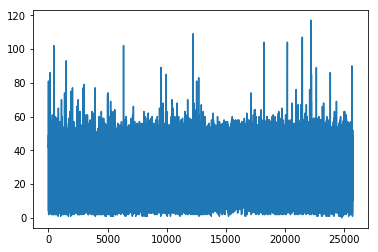

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
seq_lengths = [len(x) for x in sequences]
plt.plot(seq_lengths)
max(seq_lengths)

Wow, the longest tweet is 117 words long... I'm quite curious about what the tweet is about so let's see.

In [14]:
texts[np.argmax(seq_lengths)]

"@AmyWillRaceAmy1 @alphafemale777 @Paul_Vindici @ncanarchist @Trump_guilty @Nina82997364 @_Ourlittlesatan @iamamber7____ @JillGregory15 @huff_angie @Szyszk_e @itstimetoriseX @hotstreek420 @TuesdayTMoney @TheMJJDynasty @Marjala2 @jacarpb @zacmacme @KellyBu77326182 @Randomacc531 @John_Hamilton_C @WnJSupporter @RealMJFacts @krosodgo @leavingmyseIf @Joquin67208074 @CharlieCatlife @evelyne1370 @Hammertonhal @jak_jeremy @annettaaa @LilMissK111 @ml_roussea @ObserverReport @CherylDiamond18 @averyroseaxl @JpGoLuz @GRosario_pr77 @0pinion8d @_MJBeLike @finehats1 @I_am_DirtyHarry @AntonTerry85 @Michelleheald6 @betrayed_bitch @dash4442 @anthonyking1 @akaurer @Cougarchic I have genius 😉Just because I don't take sad music as concrete proof does not mean I didn't see it.The point was: The COURT already ruled and the man is guilty. And with all the whole that has been shot in it with all those lies. My guess is the appeal won't go far either."

Okay back to the task, as seen from the graph, the tweets vary quite a lot in length, and maxes out at 117. We will now pad all of them to 117.

In [15]:
MAX_SEQUENCE_LENGTH = max(seq_lengths)

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

## Creating One Hot Encoding Labels

In [16]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25758, 117)
Shape of label tensor: (25758, 6)


## Splitting the data into a train test split

What this means is that we will allocate 80% of our cleaned up dataset for training the neural network. After every epoch (cycle) of training, the model will be "examined" against the other 20%, named the validation set, to see how well our model generalises (whether our model is 'memorising' its training set, which is undesirable).

In [17]:
# we shuffle our sorted data, to make it random first
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# before we begin to split them
num_training_samples = int(TRAINING_SPLIT * data.shape[0])

In [18]:
x_train = data[:num_training_samples]
y_train = labels[:num_training_samples]
x_val = data[num_training_samples:]
y_val = labels[num_training_samples:]

## Preparing Embedding Matrix

In [19]:
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

## Defining and creating our model

In [20]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Bidirectional(LSTM(256))(embedded_sequences)
y = Dropout(0.5)(x)

preds = Dense(labels.shape[1], activation='softmax')(y)
model = Model(sequence_input, preds)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 117)               0         
_________________________________________________________________
embedding (Embedding)        (None, 117, 100)          6709500   
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               731136    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 3078      
Total params: 7,443,714
Trainable params: 734,214
Non-trainable params: 6,709,500
_________________________________________________________________


In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

## Training the model

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint("best_weights.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(patience=4, monitor='acc')
callbacks = [earlystopping, checkpoint]

model.fit(x_train, y_train,
          batch_size=32,
          epochs=50,
          validation_data=(x_val, y_val),
          callbacks=callbacks,
          verbose=2)

model.load_weights("best_weights.hdf5")

print("DONE")

Train on 20606 samples, validate on 5152 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.93109, saving model to best_weights.hdf5
 - 193s - loss: 0.6475 - acc: 0.7846 - val_loss: 0.2567 - val_acc: 0.9311
Epoch 2/50

Epoch 00002: val_acc improved from 0.93109 to 0.97186, saving model to best_weights.hdf5
 - 193s - loss: 0.1517 - acc: 0.9600 - val_loss: 0.1042 - val_acc: 0.9719
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.97186
 - 191s - loss: 0.1092 - acc: 0.9697 - val_loss: 0.0961 - val_acc: 0.9705
Epoch 4/50

Epoch 00004: val_acc improved from 0.97186 to 0.97651, saving model to best_weights.hdf5
 - 192s - loss: 0.1118 - acc: 0.9709 - val_loss: 0.0812 - val_acc: 0.9765
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.97651
 - 191s - loss: 0.0832 - acc: 0.9765 - val_loss: 0.1011 - val_acc: 0.9742
Epoch 6/50

Epoch 00006: val_acc did not improve from 0.97651
 - 190s - loss: 0.0735 - acc: 0.9783 - val_loss

## Making predictions with the model

Our model is now trained! We have come to the exciting part where we try to make predictions with our model and see how well it predicts whether a tweet sounds happy or sad. Give it a try with your own input!

In [24]:
def predict_tweet(text_to_predict):
    test_sequence = tokenizer.texts_to_sequences([text_to_predict])
    test_data = pad_sequences(test_sequence, maxlen=MAX_SEQUENCE_LENGTH)
    predictions = model.predict(test_data)
    prediction = np.argmax(predictions)
    print("The person who tweeted this is {}\n".format(classes_index[prediction]))
    ranking = predictions.argsort()[-6:][::-1]
    for i in reversed(range(0, 6)):
        rank = ranking[0][i]
        print("{:>10} : {:.5f}%".format(classes_index[rank], predictions[0][rank]*100))

In [25]:
predict_tweet("If I just disappear from the world right now, will anyone even care?")

The person who tweeted this is suicidal

  suicidal : 63.40141%
 depressed : 18.13954%
  cheerful : 6.18711%
       sad : 6.14780%
     happy : 5.57230%
 overjoyed : 0.55182%


In [27]:
predict_tweet("Nobody can understand the stress and anxiety that exists within me right now. Nobody cares.")

The person who tweeted this is depressed

 depressed : 50.97240%
  suicidal : 47.91130%
  cheerful : 0.52024%
       sad : 0.37566%
     happy : 0.12476%
 overjoyed : 0.09564%


In [34]:
predict_tweet("When I'm training my neural network, I can't watch netflix because it lags like crazy. Sigh")

The person who tweeted this is sad

       sad : 45.75953%
     happy : 30.72130%
 overjoyed : 15.37705%
  cheerful : 7.13586%
 depressed : 0.59173%
  suicidal : 0.41452%


In [35]:
predict_tweet("Today seems like a fine day. I can't wait to go to school today.")

The person who tweeted this is happy

     happy : 49.70885%
  cheerful : 21.92664%
  suicidal : 19.15106%
       sad : 4.73569%
 depressed : 3.61531%
 overjoyed : 0.86246%


In [36]:
predict_tweet("Wow your scrambled eggs are delicious!")

The person who tweeted this is cheerful

  cheerful : 73.66031%
     happy : 16.02193%
       sad : 4.32910%
 depressed : 3.08085%
  suicidal : 1.86836%
 overjoyed : 1.03945%


In [37]:
predict_tweet("I am so excited for Avengers Endgame actually")

The person who tweeted this is overjoyed

 overjoyed : 44.64616%
  suicidal : 29.85086%
     happy : 9.41580%
  cheerful : 7.27963%
 depressed : 4.47687%
       sad : 4.33067%


In [38]:
model.save("mood_detection_model.h5")